In [7]:
import argparse
import json
import os
import pathlib
import pickle as pkl
import shutil
import sys
import time
import warnings
from collections import defaultdict
from typing import Dict, List, Optional

import awkward as ak
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

### schema
import uproot
from coffea import nanoevents, processor
from coffea.analysis_tools import PackedSelection, Weights
from coffea.nanoevents import BaseSchema, NanoAODSchema, NanoEventsFactory
from coffea.nanoevents.methods import candidate, vector

import mplhep as hep

plt.style.use(hep.style.CMS)

### awkward 1.10.0
sys.path.append("../")

nanoevents.PFNanoAODSchema.mixins["PFCands"] = "PFCand"
nanoevents.PFNanoAODSchema.mixins["SV"] = "PFCand"

warnings.filterwarnings("ignore", message="Found duplicate branch ")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Missing cross-reference index ")
warnings.filterwarnings("ignore", message="divide by zero encountered in log")
np.seterr(invalid="ignore")

/Users/melissaquinnan/miniconda3/envs/rootstuff/lib/python3.8/site-packages/numba/core/cpu.py:99: UserWarning: Numba extension module 'awkward.numba' failed to load due to 'AttributeError(module 'awkward.numba' has no attribute 'register')'.
  numba.core.entrypoints.init_all()


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [8]:
#!pip install coffea
#!pip install pyarrow

In [9]:
#stuff from farouks notebook https://github.com/quinnanm/weaver-core-dev/blob/dev-incl-train/notebooks/mass_regression_studies.ipynb
legend_dict = {
    "higgs": "Matched Higgs",
    "W": "W+Jets",
    "W_merged": "W merged",
    "W_unmatched": "W unmatched",
    "top": "TTbar",
    "top_fully_merged": "Top: fully merged",
    "top_W_merged": "Top: only W merged",
    "top_unmatched": "Top: unmatched",
    "qcd": "QCD"
}

legend_dict = {
    "higgs": "Matched Higgs",
    "W": "W+Jets",
    "W_merged": "W merged",
    "W_unmatched": "W unmatched",
    "top": "TTbar",
    "top_fully_merged": "Top: fully merged",
    "top_W_merged": "Top: only W merged",
    "top_unmatched": "Top: unmatched",
    "qcd": "QCD"
}

def make_1d_hists(sample, events, config, tagger_cuts, bins):
    """
    Args
        sample [str]: choices are 
            ["higgs", "W_merged", "W_unmatched", "top_fully_merged", "top_W_merged", "top_unmatched", "qcd"]
        events [uproot Tree]: the uproot event Tree
        config [str]: the regressed mass config (if "ParT" then will use the ParT mass)
        tagger_cuts [list]: list of tagger cuts to make
        bins [int]: histogram bins
        
    Returns
        a 1d-plot of histograms of the `config` provided after different tagger cuts

    """
    
    
    if config == "ParT":
        for key in events:
            events = events[key]
            break
    else:
        events = events[config]
    
    show_target_mass = None
    if sample == "higgs":
        matched = (events["class_H"].array())
        show_target_mass = 125

    elif sample == "W_merged":
        matched = (events["class_W"].array())
        show_target_mass = 80
    elif sample == "W_unmatched":
        matched = (events["class_W_unmatched"].array())   
    elif sample == "W":
        matched = (events["class_W"].array()) | (events["class_W_unmatched"].array())
        
      
    elif sample == "top_fully_merged":
        matched = (events["class_Top_bW"].array())   
        show_target_mass = 175
    elif sample == "top_W_merged":
        matched = (events["class_Top_W"].array())   
        show_target_mass = 80
    elif sample == "top_unmatched":
        matched = (events["class_Top_unmatched"].array()) 

    elif sample == "top":
        matched = (events["class_Top_bW"].array()) | (events["class_Top_W"].array()) | (events["class_Top_unmatched"].array())
        
    elif sample == "qcd":
        matched = (events["class_QCD"].array())            

    # make the plot
    fig, ax = plt.subplots(figsize=(12, 9))
    
    if show_target_mass:
        ax.axvline(show_target_mass, color="red", linestyle="--", label=rf"Target mass")
    
    for tagger_wp in tagger_cuts:
        
        if tagger_wp == 0:
            title = f"No tagger cut"
        else:
            title = f"Tagger>{tagger_wp}"
    
        tagger_cut = events["fj_ParT_inclusive_score"].array() > tagger_wp

        if config == "ParT":
            x = events["fj_ParT_mass"].array()[matched & tagger_cut]
            ax.set_xlabel(f"ParT regressed mass")          
        else:
            x = events["output_target_mass"].array()[matched & tagger_cut]              
            ax.set_xlabel(f"Regressed mass ({config})")   
            
        ax.hist(
            x, 
            bins=np.linspace(0,250,bins), 
            density=True, 
            histtype="step", 
            linewidth=2, 
            label=rf"{title} ($\mu$={np.mean(x):.1f}, $\sigma$={np.std(x):.1f})"
        )

    ax.set_ylabel("Events")  
    ax.legend()
    
    hep.cms.lumitext(
        f"{legend_dict[sample]}", ax=ax, fontsize=20
    )
    hep.cms.text("Work in Progress", ax=ax, fontsize=15)
    
    
    if not os.path.exists(f"/Users/melissaquinnan/Lab/2019/2022/UCSD/2023/hww/mass_regression_{config}"):
        os.makedirs(f"/Users/melissaquinnan/Lab/2019/2022/UCSD/2023/hww/mass_regression_{config}")
    
    plt.savefig(f"/Users/melissaquinnan/Lab/2019/2022/UCSD/2023/hww/mass_regression_{config}/1d-{sample}.pdf")    
    

In [18]:
#load file
events = {}
events["discov1"] =  uproot.open("/Users/melissaquinnan/Lab/2019/2022/UCSD/2023/hww/disco_l100/pred.root")["Events"]

for key in events.keys():
    print(events[key].keys())
    break

['target_mass', 'output_target_mass', 'fj_pt', 'fj_msoftdrop', 'fj_eta', 'fj_phi', 'fj_Top_nquarksnob', 'class_H', 'class_QCD', 'class_W', 'class_W_unmatched', 'class_Top_W', 'class_Top_bW', 'class_Top_unmatched', 'fj_ParT_mass', 'fj_ParT_inclusive_score']


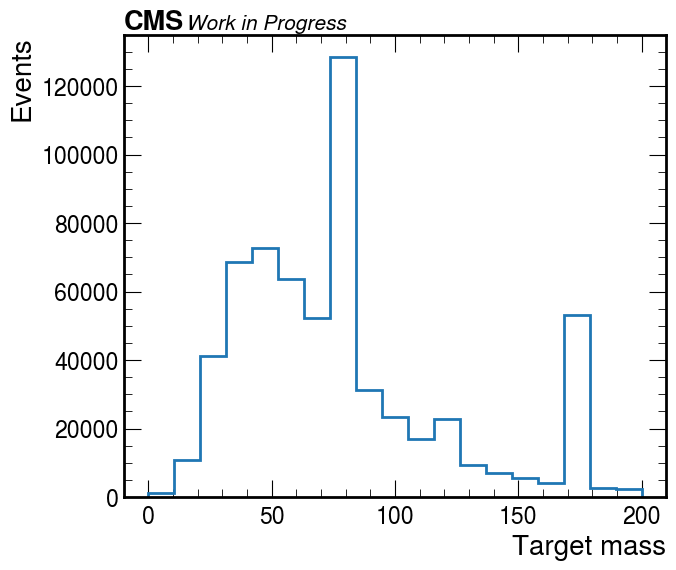

In [19]:
#copy farouk's plotting stuff
plt.rcParams.update({"font.size": 20})

# plot histogram
fig, ax = plt.subplots(figsize=(7, 6))

ax.hist(events[key]["target_mass"].array(), bins=np.linspace(0,200,20), histtype="step", linewidth=2, label="target_mass")

ax.set_ylabel("Events");  
hep.cms.lumitext(
#     "Matched Higgs samples", ax=ax, fontsize=20
)
hep.cms.text("Work in Progress", ax=ax, fontsize=15)
ax.set_xlabel("Target mass")
plt.savefig("/Users/melissaquinnan/Lab/2019/2022/UCSD/2023/hww/disco_l100/disco_target_mass.pdf")

In [16]:
#!pip install zstandard
#!pip install lz4 xxhash

  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/8b/3f/5dd06a09585247bce9436f653f90e3230a0fa091d6947748624d684b2355/xxhash-3.3.0-cp38-cp38-macosx_10_9_x86_64.whl.metadata


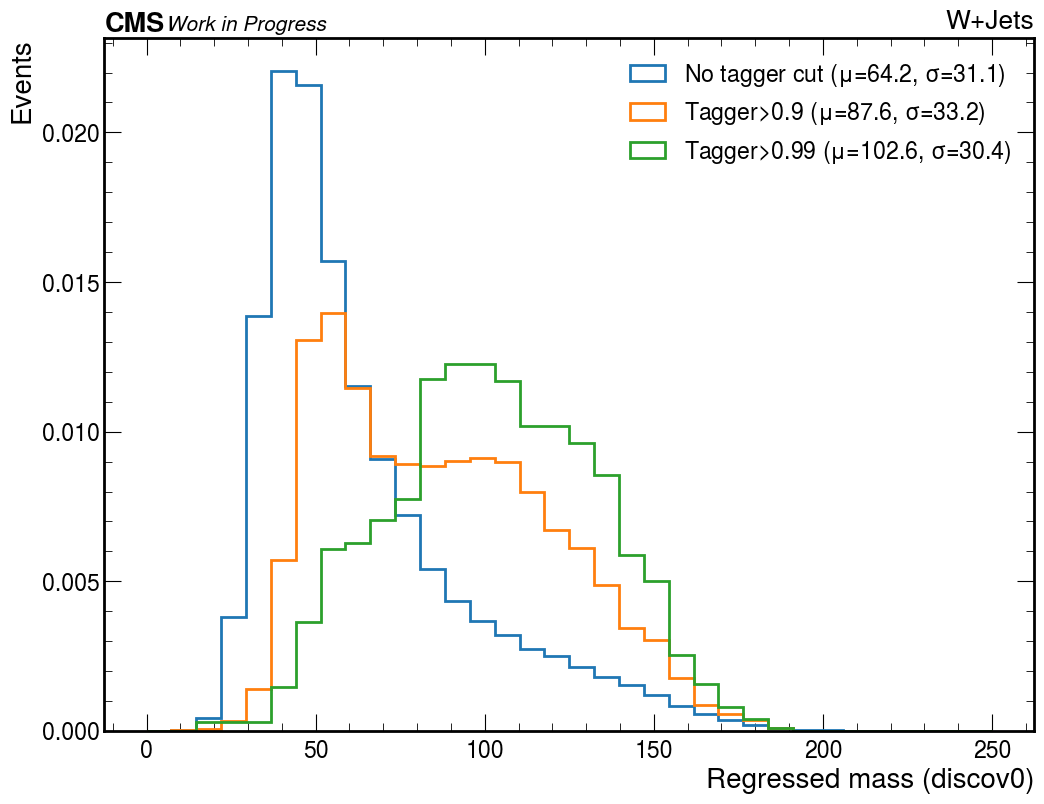

In [23]:
#still following farouk's example
make_1d_hists("W", events, "discov0", [0,0.9, 0.99], bins=35)

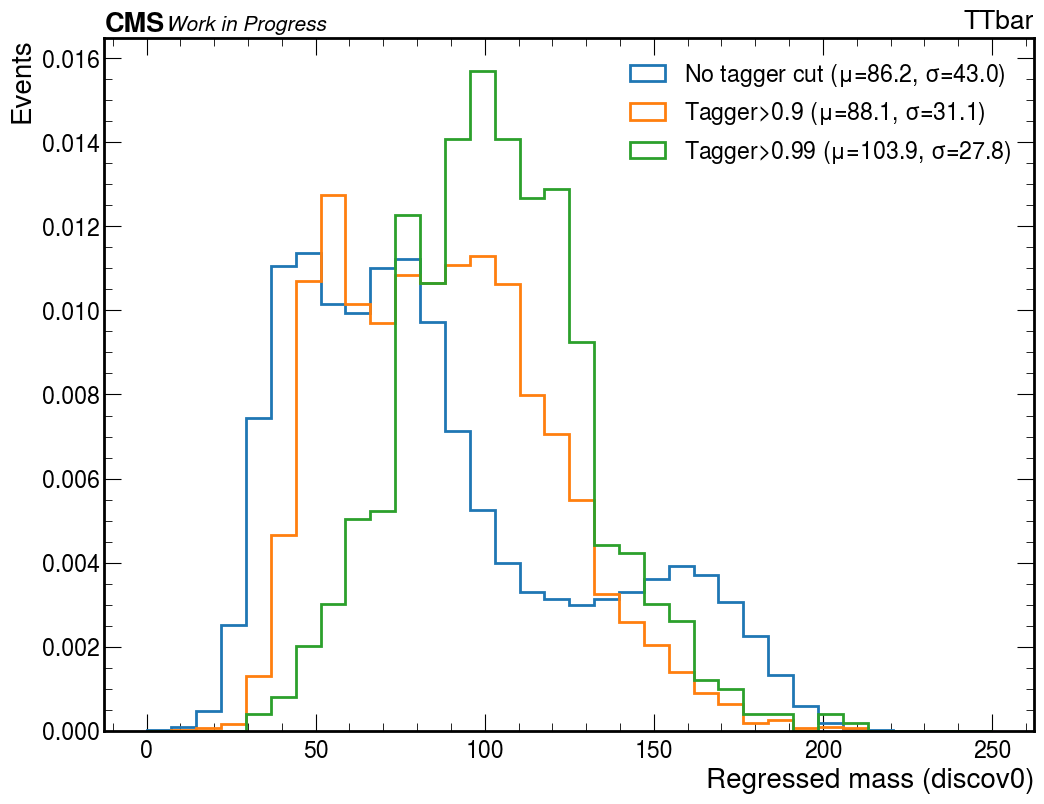

In [24]:
make_1d_hists("top", events, "discov0", [0,0.9, 0.99], bins=35)


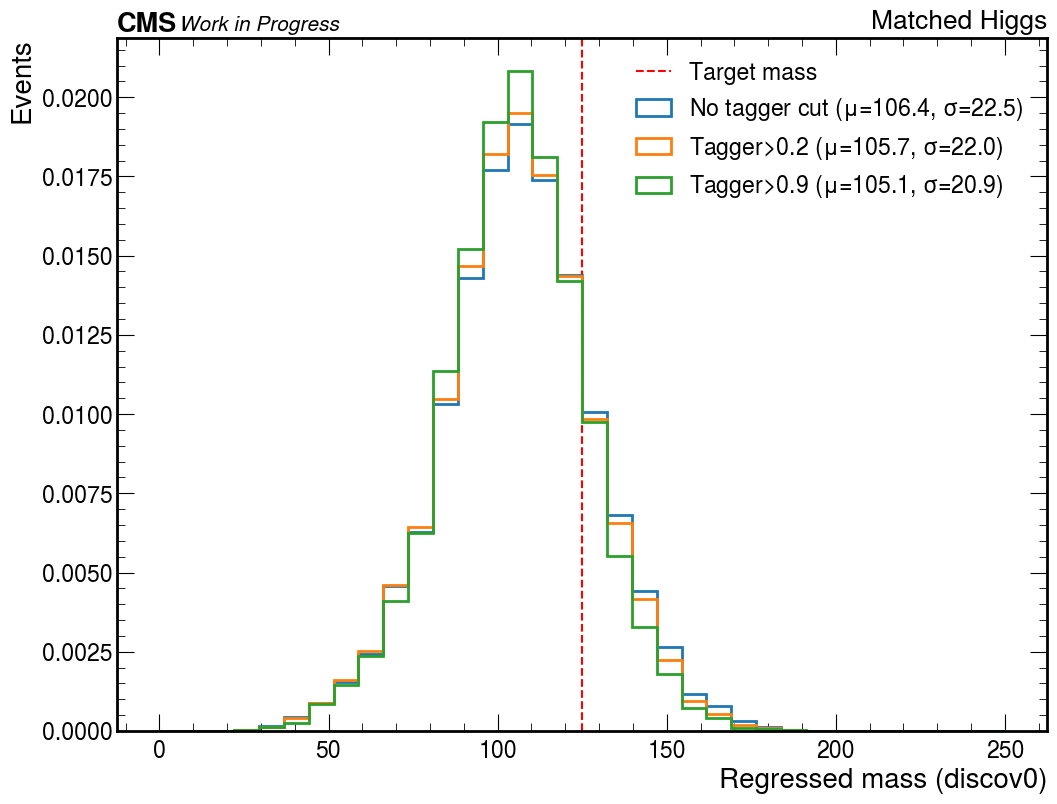

In [25]:
make_1d_hists("higgs", events, "discov0", [0,0.2, 0.9], bins=35)